<a href="https://colab.research.google.com/github/Satrio-Arif/Discoffery/blob/ML/Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pathlib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
print(tf.__version__)

2.8.2


# Importing Dataset

In [ ]:
# coffee_prices(06062022).csv
!gdown --id 1MAZAavEMYcS7kb0aLHd7A9mpiq1kd8rw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MAZAavEMYcS7kb0aLHd7A9mpiq1kd8rw
To: /content/coffee_prices(06062022).csv
100% 283k/283k [00:00<00:00, 105MB/s]


## Visualize the closing price history


In [ ]:
# Read dataset from csv file
df=pd.read_csv('coffee_prices(06062022).csv')

In [ ]:
# Showing first 5 rows from dataset
df.head()

,Unnamed: 0,date,value
0,0,1973-08-20,21533
1,1,1973-08-21,21454
2,2,1973-08-22,21038
3,3,1973-08-23,21342
4,4,1973-08-24,21294


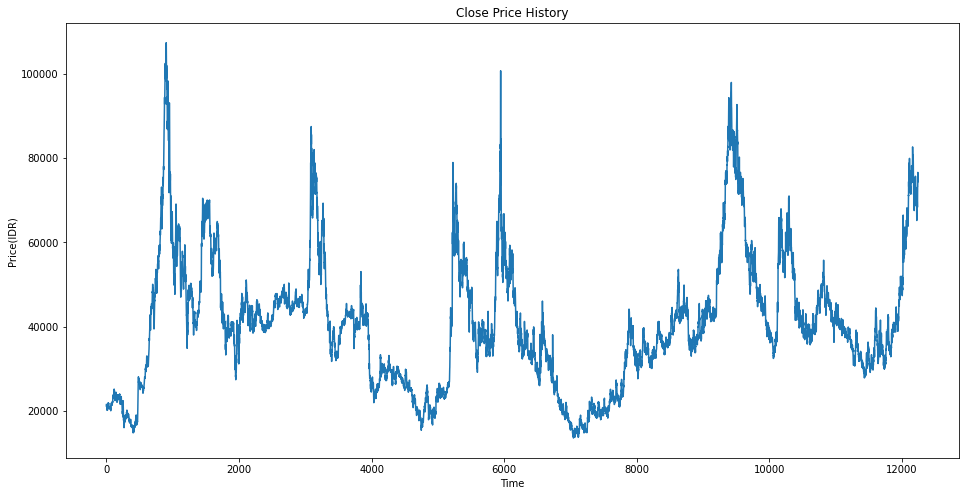

In [ ]:
# Visualize the dataset to graph 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['value'])
plt.xlabel('Time')
plt.ylabel('Price(IDR)')
plt.show()

In [ ]:
# Show dataset size
df.shape

(12242, 3)

# Split and scale the Dataset for training

In [ ]:
# Split 80% data into training data
data = df.filter(['value'])
dataset = data.values
training_data_len = math.ceil(len(dataset)* .8 )

In [ ]:
# Show training data size
training_data_len

9794

In [ ]:
# Normalize dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.08477289],
       [0.08392996],
       [0.07949126],
       ...,
       [0.66779057],
       [0.64783773],
       [0.66541117]])

In [ ]:
# Split scaled_data to train data size
train_data = scaled_data[0:training_data_len , :]

x_train = []
y_train = []

# Taking 60 days as a one record for training data
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
# Create an array 
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Reshaping data to fit into LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(9734, 60, 1)

# Model Training using Bidirectional LSTM

In [ ]:
# Building Model using Bidirectional LSTM
batch_size = 256
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[x_train.shape[1], 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 60)            360       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 512)          649216    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 256)          656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 60, 64)            16448     
                                                                 
 dense_1 (Dense)             (None, 60, 32)            2080      
                                                                 
 flatten (Flatten)           (None, 1920)              0

In [ ]:
# Set the optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Running model
history = model.fit(x_train, y_train, epochs=30, batch_size=batch_size)

Epoch 1/30
39/39 [==============================] - 27s 57ms/step - loss: 2.4469 - mae: 0.9301
Epoch 2/30
39/39 [==============================] - 2s 53ms/step - loss: 0.0921 - mae: 0.2176
Epoch 3/30
39/39 [==============================] - 2s 53ms/step - loss: 0.0522 - mae: 0.1488
Epoch 4/30
39/39 [==============================] - 2s 54ms/step - loss: 0.0397 - mae: 0.1299
Epoch 5/30
39/39 [==============================] - 2s 53ms/step - loss: 0.0314 - mae: 0.1157
Epoch 6/30
39/39 [==============================] - 2s 54ms/step - loss: 0.0261 - mae: 0.1063
Epoch 7/30
39/39 [==============================] - 2s 54ms/step - loss: 0.0211 - mae: 0.0956
Epoch 8/30
39/39 [==============================] - 2s 54ms/step - loss: 0.0172 - mae: 0.0862
Epoch 9/30
39/39 [==============================] - 2s 55ms/step - loss: 0.0135 - mae: 0.0764
Epoch 10/30
39/39 [==============================] - 2s 55ms/step - loss: 0.0105 - mae: 0.0673
Epoch 11/30
39/39 [==============================] - 2s 55

# Split and scale the Dataset for testing

In [ ]:
# Split scaled_data to test data size
test_data = scaled_data[training_data_len - 60 : , :]
x_test = []
y_test = dataset[training_data_len:, :]

# Taking 60 days as a one record for testing data
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Create an array
x_test = np.array(x_test)

In [ ]:
# Reshaping data to fit into LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(2448, 60, 1)

# Get the Models Predicted

In [ ]:
# Get the models predicted
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Calculate the RMSE (Root Mean Square Error)
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

67.64817979600694

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


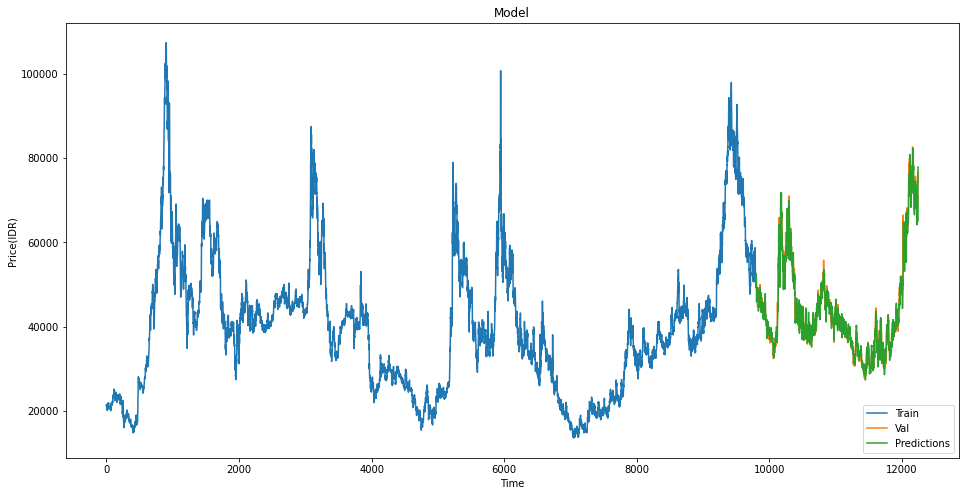

In [ ]:
# Visualize the models predicted
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Price(IDR)')
plt.plot(train['value'])
plt.plot(valid[['value','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the value of models predicted
valid

,value,Predictions
9794,51636,49408.839844
9795,50708,50320.285156
9796,51684,51196.597656
9797,52595,51799.308594
9798,51428,51778.417969
...,...,...
12237,73936,68477.101562
12238,76558,69052.742188
12239,76174,72543.117188
12240,74304,76954.554688


# Predicted Price

In [ ]:
# Show test data size
len(test_data)

2508

In [ ]:
# Taking last 60 days of testing data
fut_inp = test_data[2448:]

In [ ]:
# Reshape the data into 2 dimensional
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
# Turn the data into list format
tmp_inp = list(fut_inp)

In [ ]:
# Show data size
fut_inp.shape

(1, 60)

In [ ]:
# Convert the data elements of an array into a list
tmp_inp = tmp_inp[0].tolist()

In [ ]:
# Predict the coffee price for the next 30 days
lst_output=[]
n_steps=60
i=0
while(i<30):
    
    if(len(tmp_inp)>60):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6662189364433289], [0.6811560392379761], [0.6718484163284302], [0.6553118824958801], [0.6303112506866455], [0.6149187088012695], [0.6054255366325378], [0.6031453013420105], [0.61353999376297], [0.620387077331543], [0.6308752298355103], [0.6243112683296204], [0.6193689703941345], [0.6400286555290222], [0.6583120226860046], [0.6666853427886963], [0.6649680137634277], [0.6635802984237671], [0.6520118117332458], [0.6444718241691589], [0.6279967427253723], [0.6280987858772278], [0.6249266862869263], [0.6014230847358704], [0.588095486164093], [0.5911114811897278], [0.6048049330711365], [0.6049352884292603], [0.6076003909111023], [0.612285315990448]]


In [ ]:
# Split data for 2 plot
plot_new=np.arange(1,61)
plot_pred=np.arange(61,91)

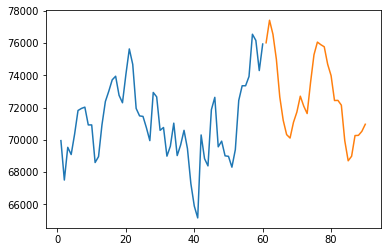

In [ ]:
# Visualize predictions result
plt.plot(plot_new, scaler.inverse_transform(scaled_data[12182:]))
plt.plot(plot_pred, scaler.inverse_transform(lst_output))

In [ ]:
 # Show price predictions values
 scaler.inverse_transform(lst_output)

array([[76026.70494241],
       [77426.62515342],
       [76554.30542672],
       [75004.4849394 ],
       [72661.4007256 ],
       [71218.79630756],
       [70329.08671874],
       [70115.38078707],
       [71089.58175546],
       [71731.29727459],
       [72714.25741541],
       [72099.07637912],
       [71635.87927431],
       [73572.12562484],
       [75285.66107816],
       [76070.4170115 ],
       [75909.46721792],
       [75779.40914857],
       [74695.19900745],
       [73988.54383296],
       [72444.48272496],
       [72454.0463112 ],
       [72156.7539655 ],
       [69953.97292453],
       [68704.89705878],
       [68987.55912858],
       [70270.92313236],
       [70283.14016688],
       [70532.91623658],
       [70971.99209994]])

# Model Evaluation 

In [ ]:
tf.keras.metrics.mean_absolute_error(y_train, predictions).numpy()

array([49408.56 , 50320.004, 51196.312, ..., 72542.836, 76954.266,
       77808.555], dtype=float32)

<Figure size 432x288 with 0 Axes>

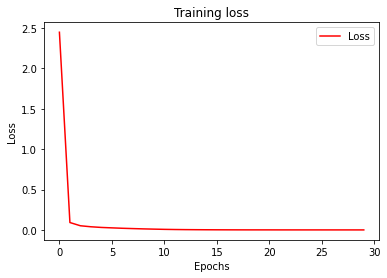

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


# Save Model

In [ ]:
# Convert model to saved_model format
model.save('model_v4.h5')
model.save('model_v4')
!zip -r 'model_v4.zip' 'model_v4'

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets


updating: model_v4/ (stored 0%)
updating: model_v4/saved_model.pb (deflated 90%)
updating: model_v4/keras_metadata.pb (deflated 92%)
updating: model_v4/assets/ (stored 0%)
updating: model_v4/variables/ (stored 0%)
updating: model_v4/variables/variables.data-00000-of-00001 (deflated 6%)
updating: model_v4/variables/variables.index (deflated 70%)


In [ ]:
# Convert model to TfLite
converter = tf.lite.TFLiteConverter.from_saved_model('model_v4')

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model_v4.tflite')
tflite_model_file.write_bytes(tflite_model)

5351804